# **Heart Disease Predictive Analytics**
**Objective**: Understanding the main contributors to heart disease and building a predictive model that can effectively detect a person’s propensity of having heart disease

**Dataset Description**: The dataset source is from a 2020 annual CDC survey data of 400k adults related to their health status, and contains the variable “HeartDisease” which indicates if a respondent had heart disease. In addition, variables indicating the health status/lifestyle habits of respondents are included.

**Modelling Approach**: We intend to structure the problem as a Supervised Classification problem where we predict on the label “HeartDisease” (indicating whether a person will/will not contract heart disease)

**Stages of our analysis**
1. Data Cleaning (understanding features and datatypes, handling missing values, data impute)
2. Feature Engineering
3. Exploratory Data Analysis (visualizations, correlations etc.)
4. Data Preprocessing for ML (train test splits, scaling, encoding, PCA, oversampling)
5. Modeling (Model Training, Hyperparameter Tuning, Feature Importance etc.)


## Import Packages

In [ ]:
!pip install scikit-optimize

# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
from matplotlib import cm
import matplotlib.ticker as mtick
from collections import Counter

#Preprocessing Packages
from sklearn.model_selection import train_test_split

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from xgboost import XGBClassifier

#Preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#Metrics
from sklearn.metrics import precision_score, recall_score, \
f1_score, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.4 MB/s eta 0:00:00


# 1. Data Reading and Cleaning

**Description**: We first read the dataset through a mounted Google Drive, and inspect the dataset for any nulls and duplicates (performing any data imputation or dropping of rows as required)

## 1.1 Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- We read the data and inspect the dataset using .head()

In [ ]:
#After adding shortcut "CIS5450 Group Project" folder to /drive/MyDrive"
df_heart = pd.read_csv('/content/drive/MyDrive/CIS5450 Group Project/heart_2020_cleaned.csv')
# df_heart = pd.read_csv('/content/drive/MyDrive/heart_2020_cleaned.csv')
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


- Next, we observe the data types of the dataset
- We can see that there is a mixture of categorical and numerical features - with "HeartDisease" being the label

In [ ]:
df_heart.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

## 1.2 Check Nulls and Duplicates

- First, we check for Nulls. In a scenario where there are nulls present, we can either consider dropping the rows or perform data imputation (through simple methods like mean imputation, or more complex ones like KNN imputation)
- In this scenario, there are no nulls present in the dataset

In [ ]:
num_nulls = int(df_heart.isnull().any(axis=1).sum())
num_nulls

0

- Next, we check for any duplicated rows. If there are duplicates present, we can first inspect the data to see if the duplicates are "legitimate" - for example, if the rows are fully duplicates, there is a high probability that it is genuine as there is low likelihood for 2 people to have the exact same health attributes
- In this scenario, there are no duplicates present in the dataset

In [ ]:
num_dups = int(len(df_heart) - len(df_heart.duplicated()))
num_dups

0

# 2. Feature Engineering

**Description**: In order to maximize the value of the dataset, we perform a series of Feature Transformation/Engineering steps like encoding (for categorical variables) and engineering (creating new variables) that could potentially have stronger relationships with the target variable

## 2.1 Categorical Encoding

- First, we differentiate the categorical variables by Ordinal (having a natural ordered relationship) and Nominal variables (without natural order)
- By having the separation, we can better extract the inherent information/relationship of the categorical variables (for example, we can easily perform correlation analysis between Ordinal variables and our label)

In [ ]:
# Ordinal Encoding
ordinal_categorical_cols = ['AgeCategory', 'GenHealth']

agecategory_dict = {'18-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5,
                    '45-49': 6, '50-54': 7, '55-59': 8, '55-59': 9, '60-64': 10,
                    '65-69': 11, '70-74': 12, '75-79': 13, '80 or older': 14}

genhealth_dict = {'Poor': 1, 'Fair': 2, 'Good': 3, 'Very good': 4, 'Excellent': 5}

encoded_df_heart = df_heart.copy()
encoded_df_heart['AgeCategory'] = encoded_df_heart['AgeCategory'].apply(lambda x: agecategory_dict[x])
encoded_df_heart['GenHealth'] = encoded_df_heart['GenHealth'].apply(lambda x: genhealth_dict[x])

In [ ]:
# Nominal (One-Hot Encoding)
nominal_categorical_cols = ['Sex', 'Race']
encoded_df_heart = pd.get_dummies(encoded_df_heart, columns=nominal_categorical_cols, drop_first=False)

## 2.2 Change Boolean features/target to numerical value
- Next, we transform the boolean features to numerical value (i.e. 1/0) as part of features transformation

In [ ]:
# encoded_df_heart = df_heart.copy()
Yes_No_cols = ['HeartDisease','Smoking','AlcoholDrinking',	'Stroke',
               'DiffWalking', 'Diabetic', 'PhysicalActivity', 'Asthma',
               'KidneyDisease', 'SkinCancer']
for col in Yes_No_cols:
    encoded_df_heart[col] = encoded_df_heart[col].map(lambda x: 1 if x=='Yes' else 0)
print(encoded_df_heart.columns)
encoded_df_heart.head()

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'AgeCategory',
       'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Sex_Female', 'Sex_Male',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White'],
      dtype='object')


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,Diabetic,...,KidneyDisease,SkinCancer,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0,16.60,1,0,0,3.0,30.0,0,9,1,...,0,1,1,0,0,0,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,14,0,...,0,0,1,0,0,0,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,11,1,...,0,0,0,1,0,0,0,0,0,1
3,0,24.21,0,0,0,0.0,0.0,0,13,0,...,0,1,1,0,0,0,0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,5,0,...,0,0,1,0,0,0,0,0,0,1


## 2.3 Feature Engineering

- We then perform a series of Feature Engineering in an attempt to extract more information from the existing variables
- Each feature engineered will be accompanied with a hypothesis - and further validated through correlation study (in the EDA section) and feature importance (in modelling section)

### 2.3.1 Feature 1: Smokes AND Drinks Alcohol

**Hypothesis**: We feel that a person who smokes AND drinks alcohol might have a higher chance for contracting heart disease. Hence, we engineer the interaction term by placing AND condition between the existing "Smoking" and "AlcoholDrinking" variable

In [ ]:
encoded_df_heart['Smoking_and_AlcoholDrinking'] = np.where((encoded_df_heart['Smoking'] == True) \
                                                           & (encoded_df_heart['AlcoholDrinking'] == True), 1, 0)

- We see that ~4% of the people in the dataset smokes and drinks alcohol

In [ ]:
encoded_df_heart['Smoking_and_AlcoholDrinking'].describe()

count    319795.000000
mean          0.041949
std           0.200472
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Smoking_and_AlcoholDrinking, dtype: float64

### 2.3.2 Feature 2: Binning BMI
**Hypothesis:** Through binning of BMI into categories (e.g. Underweight/Normal/Overweight/Obesity), we "simplify" the BMI variable which potentially could allow the models to better extract the relationship. We also hypothesize that heart disease might be correlated with the overweight category

In [ ]:
def tag_bmi_category(bmi):
  if bmi < 18.5:
    return 'underweight'
  elif bmi <= 24.9:
    return 'healthy'
  elif bmi <= 29.9:
    return 'overweight'
  else:
    return 'obesity'

- After mapping BMI to its categories, we perform an One-Hot Encoding

In [ ]:
encoded_df_heart['bmi_category'] = encoded_df_heart['BMI'].apply(lambda x: tag_bmi_category(x))
encoded_df_heart = pd.get_dummies(encoded_df_heart, columns=['bmi_category'], drop_first=False)

#3. EDA
- In the EDA exercise, we seek to understand relationships between features and label through methods like visualization and correlation study

## 3.1 Understanding Data

###3.1.1 Check data types for features and target
- Note that all features have been transformed/encoded (into numerical form) for further EDA

In [ ]:
encoded_df_heart.dtypes

HeartDisease                             int64
BMI                                    float64
Smoking                                  int64
AlcoholDrinking                          int64
Stroke                                   int64
PhysicalHealth                         float64
MentalHealth                           float64
DiffWalking                              int64
AgeCategory                              int64
Diabetic                                 int64
PhysicalActivity                         int64
GenHealth                                int64
SleepTime                              float64
Asthma                                   int64
KidneyDisease                            int64
SkinCancer                               int64
Sex_Female                               uint8
Sex_Male                                 uint8
Race_American Indian/Alaskan Native      uint8
Race_Asian                               uint8
Race_Black                               uint8
Race_Hispanic

### 3.1.2 Describe data

**Interesting Observations:**
- 8% of respondents have heart disease (important point to consider later during ML preprocessing)
- 41% of respondents smokes
- We have a close to 50/50 split of Male (48%) and Female (52%) representation
- 35% of respondents are overweight

In [ ]:
pd.options.display.max_columns = 100
encoded_df_heart.describe()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,Sex_Female,Sex_Male,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Smoking_and_AlcoholDrinking,bmi_category_healthy,bmi_category_obesity,bmi_category_overweight,bmi_category_underweight
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,8.059554,0.127588,0.775362,3.595028,7.097075,0.134061,0.036833,0.093244,0.524727,0.475273,0.016267,0.025229,0.071730,0.085824,0.034172,0.766779,0.041949,0.297497,0.327694,0.358830,0.015979
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,3.999750,0.333631,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775,0.499389,0.499389,0.126499,0.156819,0.258041,0.280104,0.181671,0.422883,0.200472,0.457158,0.469373,0.479658,0.125394
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000,1.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,9.000000,0.000000,1.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,11.000000,0.000000,1.000000,4.000000,8.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,14.000000,1.000000,1.000000,5.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3.2 Visualizations
- Next, we utilize visualizations to better illustrate potential relationships between features and label

### 3.2.1 % of people with Heart Disease for Each Age category

**Insights:**
- We see that age is positively correlated with heart disease, where there is a higher propotion of people with heart disease in higher age groups
- For example, we have >=20% of people with heart disease in age group 80 or older, where people in younger age groups <= 54 have a < 5% population with heart disease

In [ ]:
df_heart_eda = df_heart.copy()
df_heart_eda['HeartDisease'] = df_heart_eda['HeartDisease'].apply(lambda x: x == "Yes")

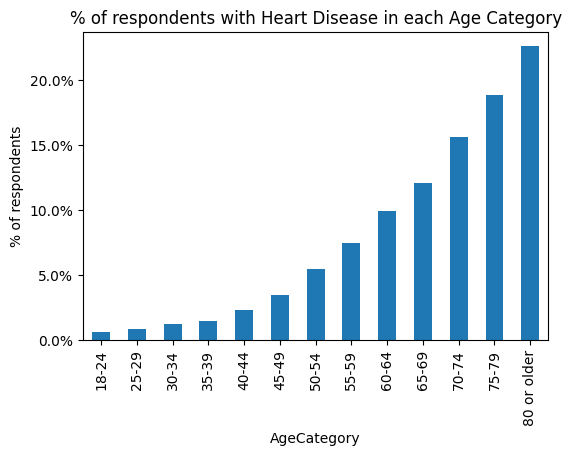

In [ ]:
heart_for_Ages = df_heart_eda[['HeartDisease', 'AgeCategory']]
ax = heart_for_Ages.groupby('AgeCategory')['HeartDisease'].mean().plot.bar(figsize=(6,4))

plt.ylabel('% of respondents')
plt.title('% of respondents with Heart Disease in each Age Category')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### 3.2.2 % of people with Heart Disease for Each Gender

**Insights**
- We see that the Male population surveyed has a higher proportion (\~10%) of people with Heart Disease compared to the Female population (\~6%)

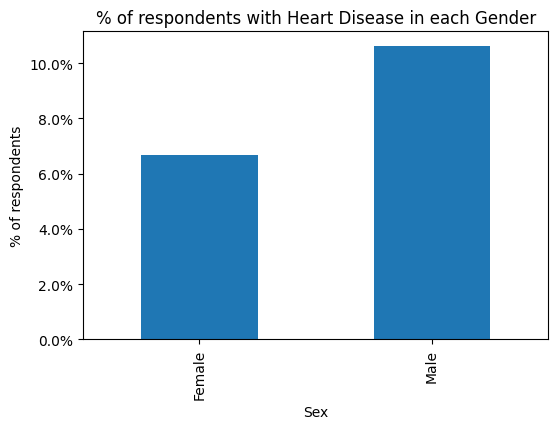

In [ ]:
heart_for_Gender = df_heart_eda[['HeartDisease', 'Sex']]
ax = heart_for_Gender.groupby('Sex')['HeartDisease'].mean().plot.bar(figsize=(6,4))

plt.ylabel('% of respondents')
plt.title('% of respondents with Heart Disease in each Gender')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### 3.2.3 % of people with Heart Disease for Each Health Condition
**Insights**
- We see a negative correlation between general health and heart disease - where \~35% of people with poor health have heart disease and \~5% of people with excellent health have heart disease
- However, we acknowledge that heart disease and general health report could have a "chicken and egg" relationship (i.e. heart disease is the reason why their general health is reported as poor, and not because their general health is poor hence they have heart disease)

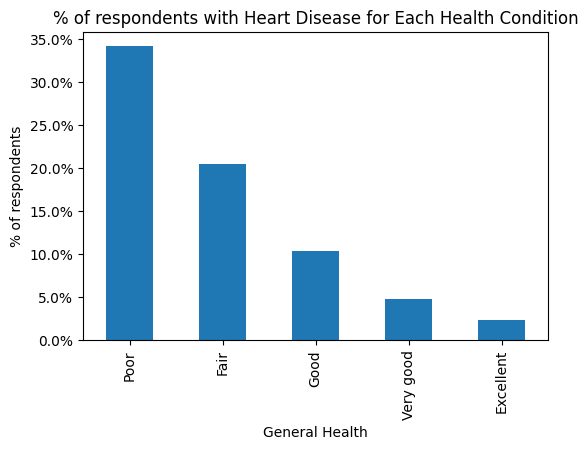

In [ ]:
heart_for_genhealth = encoded_df_heart[['HeartDisease', 'GenHealth']]
ax = heart_for_genhealth.groupby('GenHealth')['HeartDisease'].mean().plot.bar(figsize=(6,4))

ax.set_xticklabels(['Poor','Fair','Good','Very good','Excellent'])
plt.ylabel('% of respondents')
plt.xlabel('General Health')
plt.title('% of respondents with Heart Disease for Each Health Condition')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

### 3.2.4 Distribution of Sleep Time for people with/without Heart Disease
**Insights**:
- We do not see a large difference between the distribution of sleeptime between people with and without heart disease
- The median sleep time for both age group is ~7hours (interestingly, we have outliers reporting their sleep time as 24hours!)


Text(0, 0.5, 'Sleep Time (Hours)')

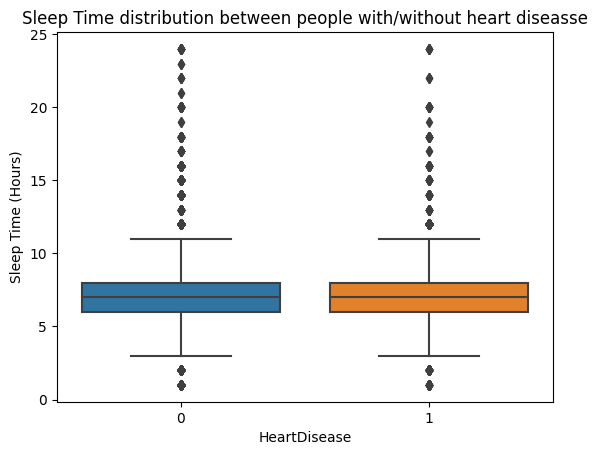

In [ ]:
sns.boxplot(data=encoded_df_heart, x='HeartDisease', y='SleepTime')

plt.title('Sleep Time distribution between people with/without heart diseasse')
plt.ylabel('Sleep Time (Hours)')

## 3.3 Correlation Heatmap

**Insights:**
- Looking at the correlations between features and label (HeartDisease), we identify the top features with highest (absolute) correlation
- AgeCategory, Stroke and DiffWalking have the highest positive correlation with our label
- GenHealth and PhysicalActivity have the highest negative correlation

In [ ]:
corr_matrix = encoded_df_heart.corr()

<Axes: >

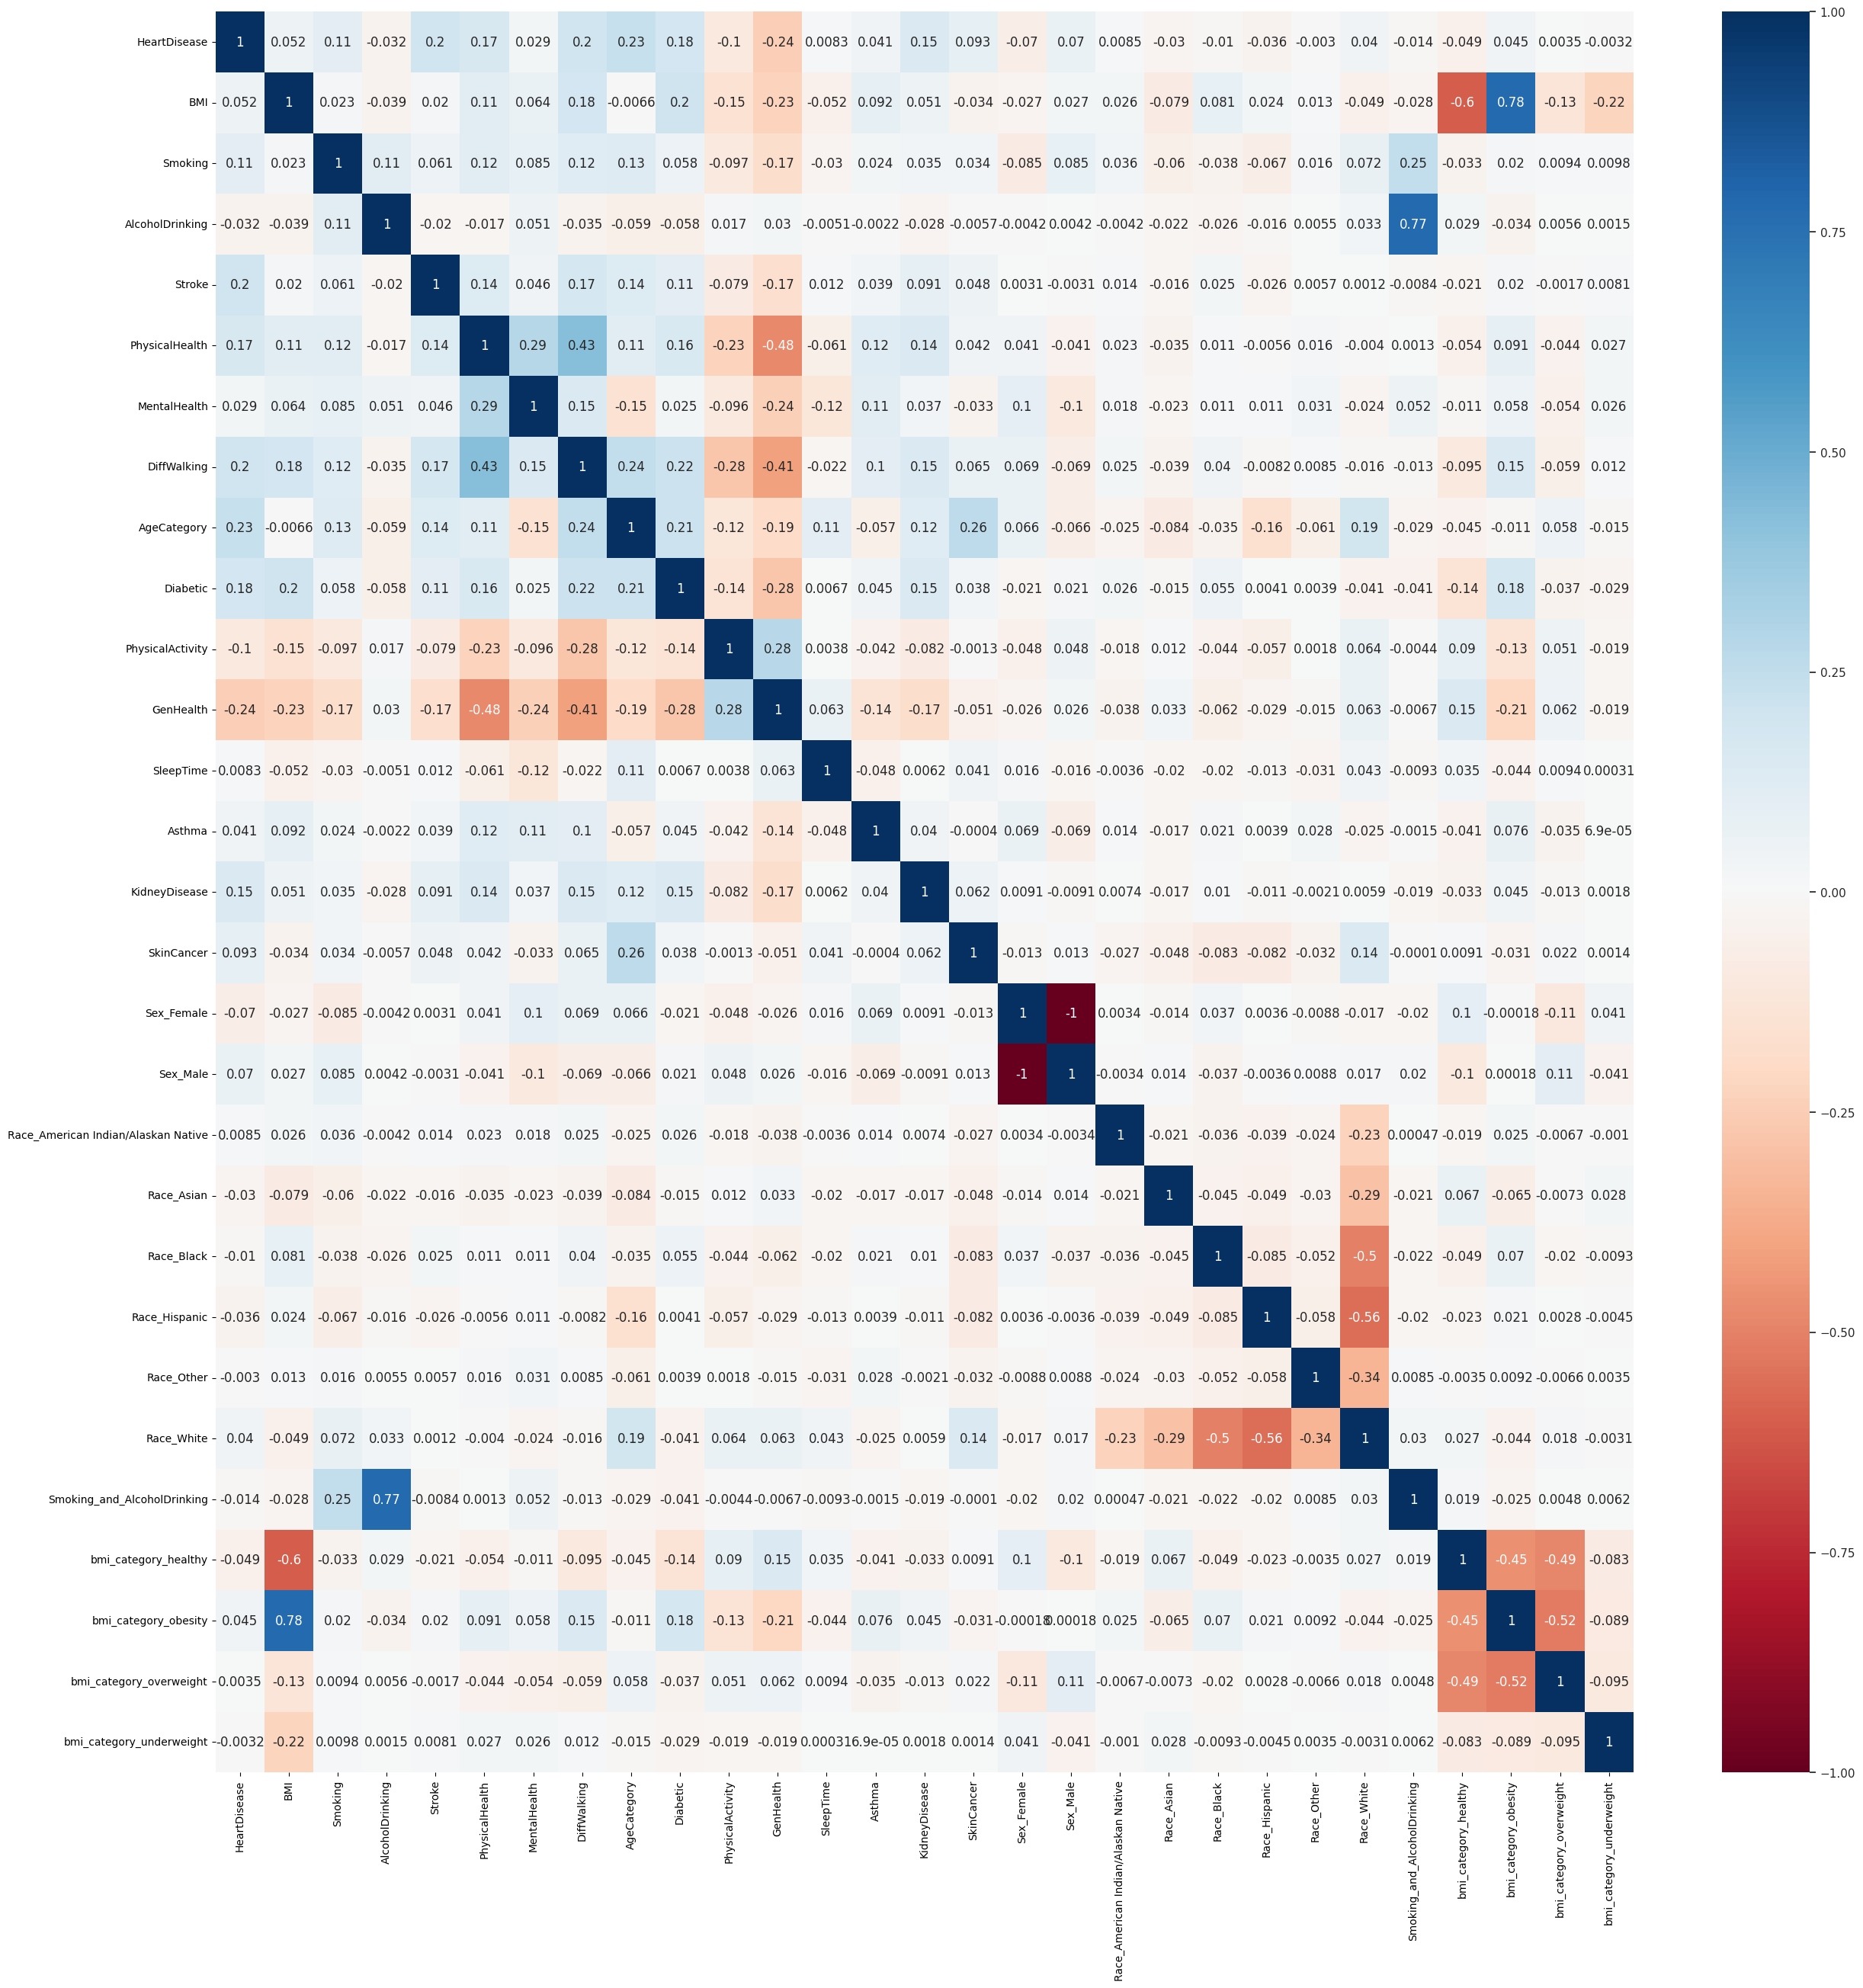

In [ ]:
plt.subplots(figsize=(30, 30))
norm = plt.Normalize(-1,1)
sns.set(font_scale=1)
sns.heatmap(corr_matrix, cmap='RdBu', norm=norm, annot=True)

#4. Data Preprocessing for ML

- We move on to conduct data preprocessing to prepare our data for modelling

### 4.1 Train and test splits
- First, we perform a train-test split - whereby we will utilize our train set for model training before using our test set for model evaluation

In [ ]:
features = encoded_df_heart.drop('HeartDisease', axis=1)
target = encoded_df_heart['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

- We see an equal distribution of labels in both Train and Test set

In [ ]:
print(f"% of heart disease in Train set: {y_train.mean() * 100}%")
print(f"% of heart disease in Test set: {y_test.mean()* 100}%")

% of heart disease in Train set: 8.51365718663519%
% of heart disease in Test set: 8.743101049109587%


### 4.2 Scaling
- As the dataset have features of different scale (e.g. BMI from 0 to 30+ vs. boolean variables with 1/0), we will utilize a StandardScaler to scale our features
- In addition, the algorithms we are using to choose (e.g. Tree-based and Gradient descent-based algos) are inherently scale sensitive

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

### 4.3 PCA

- Next, we choose to explore PCA components - these could be essentially be useful as they could capture relationships otherwise not present in our feature set
- Note that we eventually chose not to utilize PCA components as part of our model training as explainability is important in a Health Care use case (i.e. we need to explain how and what are the factors that contributed to our prediction)

In [ ]:
pca = PCA()
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

- We see that that we have >=80% cumulative explained variance rations at n=16

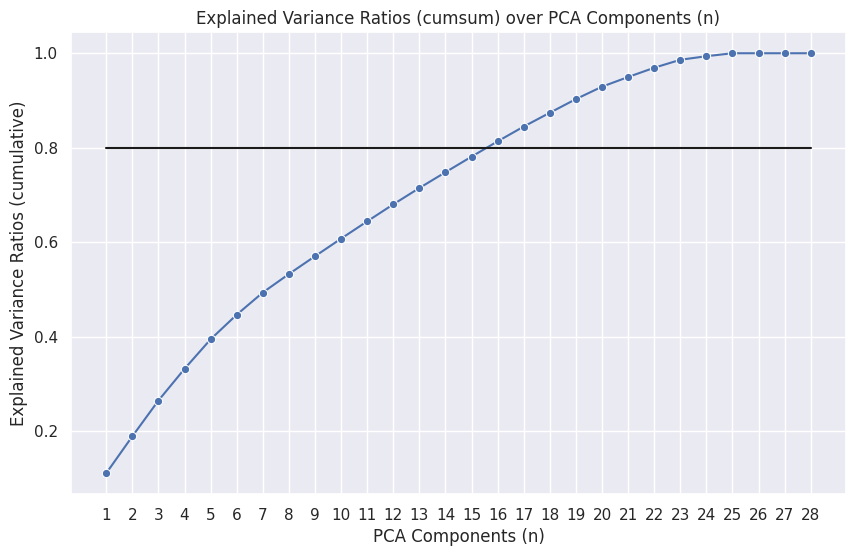

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(cum_evr, marker='o', dashes=False)

plt.xticks(np.arange(len(cum_evr)), np.arange(1, len(cum_evr)+1))
plt.xlabel('PCA Components (n)')
plt.ylabel('Explained Variance Ratios (cumulative)')
plt.title('Explained Variance Ratios (cumsum) over PCA Components (n)')
plt.plot([0, 27], [0.8, 0.8], 'k-')

### 4.4 Oversampling
- As our dataset is inherently imbalanced (~9% positive labels), there is a skewed class distribution and might lead to underpresentation of the minority class during model training
- Hence, we will be performing an oversampling of the minority class and bring the ratio to 50:50

In [ ]:
print(f"% of people with HeartDisease: {round(encoded_df_heart['HeartDisease'].mean() * 100,3)}%")

% of people with HeartDisease: 8.56%


- We decided to use the SMOTE technique, which enables a synthetic creation of data points from existing data.
- This allows creation of new data points (that are not necessarily duplicates of the current data points) - in turn enabling "new" information for the model to learn from

In [ ]:
#SMOTE
smote = SMOTE(random_state=42) #50/50 ratio
X_train_scaled_oversampled, y_train_oversampled = smote.fit_resample(X_train_scaled, y_train)

#5. Modeling

**Models Considered**: Classification Models (Logistics Regression, Random Forest, XGBoost)

**Model Evaluation**: To evaluate using **F1-score** as evaluation metric due to imbalanced dataset (e.g. if we use accuracy, even if we predict all cases to be of no heart disease, we would have high performance (which is not true))
  - We also considered utilizing **Recall** as an evalation metric, as we felt that prioritizing optimizing for False Negatives (i.e. better to inform patient that they have a heart disease, rather than missing out on the diagnosis) might be a sound strategy in this use case
  - However, we decided on F1-Score eventually that balances both Precision and Recall

In [ ]:
random_state = 42

## 5.1 Logistic Regression
- Logistic Regression model serves as a good baseline model with high interpretability, which is quintessential in a health predictive use case

### 5.1.1 Baseline Model

In [ ]:
# Initiate baseline model and train
lr_baseline = LogisticRegression(random_state=random_state)
lr_baseline.fit(X_train_scaled_oversampled, y_train_oversampled)

LogisticRegression(random_state=42)

- We see that there are signs of overfitting as the Train Set Score (0.78) is significantly higher than the Test Set Score (0.35)

In [ ]:
# Baseline model train set score
y_train_pred = lr_baseline.predict(X_train_scaled_oversampled)
print(f"Train Set Score: {f1_score(y_train_oversampled, y_train_pred)}")

# Baseline model test set score
y_pred = lr_baseline.predict(X_test_scaled)
print(f"Test Set Score: {f1_score(y_test, y_pred)}")

Train Set Score: 0.7758963126293436
Test Set Score: 0.35017267689342224


### 5.1.2 Hyperparameter Tuning

**Hyperparameters to consider:**
- C: Inverse strength of regularization; lower results in stronger regularization and lower chance of overfitting
- Penalty: (Not tuning) Will be using L2 (Ridge) regularization due to previous overfitting in baseline model

**Note:**
- We also perform 5-fold stratified cross validation, which helps to evaluate the performance of the model on "unseen" data and hence reduce the chance of overfitting eventually on the test set
- Also, we chose to utilize RandomizedSearch as the hyperparameter tuning strategy due to the better trade off between efficiency (i.e. time) and results (compared to GridSearch)

In [ ]:
# Set up params for Logistic Regression
lgr_params = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10],
}

# Initiate RandomizedSearchCV
lgr_randomized_search = RandomizedSearchCV(
    LogisticRegression(random_state=random_state),
    param_distributions=lgr_params,
    scoring='f1',
    cv=5,
    verbose=4,
    random_state=random_state
  )

# Fit data
lgr_randomized_search.fit(X_train_scaled_oversampled, y_train_oversampled)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...........................C=0.001;, score=0.772 total time=   2.3s
[CV 2/5] END ...........................C=0.001;, score=0.779 total time=   4.2s
[CV 3/5] END ...........................C=0.001;, score=0.776 total time=   2.4s
[CV 4/5] END ...........................C=0.001;, score=0.774 total time=   2.0s
[CV 5/5] END ...........................C=0.001;, score=0.778 total time=   1.9s
[CV 1/5] END ............................C=0.01;, score=0.772 total time=   1.9s
[CV 2/5] END ............................C=0.01;, score=0.779 total time=   1.0s
[CV 3/5] END ............................C=0.01;, score=0.776 total time=   2.4s
[CV 4/5] END ............................C=0.01;, score=0.774 total time=   2.8s
[CV 5/5] END ............................C=0.01;, score=0.778 total time=   1.8s
[CV 1/5] END .............................C=0.1;, score=0.772 total time=   2.1s
[CV 2/5] END .............................C=0.1;,

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': [0.001, 0.01, 0.1, 0.5, 1, 10]},
                   random_state=42, scoring='f1', verbose=4)

In [ ]:
print(f"Best hyperparamters: {lgr_randomized_search.best_params_}")
print(f"Best F1-score: {lgr_randomized_search.best_score_}")

Best hyperparamters: {'C': 0.01}
Best F1-score: 0.7759021499908302


### 5.1.3 Evaluate on test set (Default Threshold=0.5)
- We first evaluate our model on the test set, using a default (0.5)
- We see that the Test F1-Score stands at 0.35

In [ ]:
y_pred = lgr_randomized_search.predict(X_test_scaled)
print(f"Logsitic Regression Test F1-Score (default threshold): {f1_score(y_test, y_pred)}")

Logsitic Regression Test F1-Score (default threshold): 0.35009236205927236


### 5.1.4 Threshold Tuning
- Through threshold tuning, we see that the best F1-Score (0.39) can be achieved at threshold=0.714

In [ ]:
def get_optimal_threshold(classifier, X_test, y_test):
  thresholds = np.arange(0, 1, 0.001)
  y_pred_proba = classifier.predict_proba(X_test)
  probabilities = y_pred_proba[:, 1]
  scores_list = [f1_score(y_test, (probabilities >= threshold).astype('int')) for threshold in thresholds]
  ind = np.argmax(scores_list)
  best_threshold = thresholds[ind]
  best_score = scores_list[ind]
  print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_score}")
  return (best_threshold, best_score)

In [ ]:
best_lgr_threshold, best_lgr_score = get_optimal_threshold(lgr_randomized_search, X_test_scaled, y_test)

Best Threshold: 0.714, Best F1-Score: 0.3915322306173848


### 5.1.5 Final evaluation on test set using optimized threshold

In [ ]:
# Compute final model test score
y_pred_lgr = (lgr_randomized_search.predict_proba(X_test_scaled)[:, 1] >= best_lgr_threshold).astype('int')
lgr_f1score = f1_score(y_test, y_pred_lgr)
print(f"Logistic Regression F1-Score: {lgr_f1score}")

# Generate confusion matrix
print("\nLogistic Regression Confusion Matrix")
lgr_confusion = confusion_matrix(y_test, y_pred_lgr)
print(lgr_confusion)

Logistic Regression F1-Score: 0.3915322306173848

Logistic Regression Confusion Matrix
[[52144  6223]
 [ 2716  2876]]


### 5.1.6 Feature Importance
- Now, we look at the coefficients of the logistic regression model and observe which were the most important features
- By plotting the absolute coefficients of the model, we can see that the Top 2 contributing features were AgeCategory and GenHealth
- This is aligned with our EDA - where we see a correlation between these 2 variables and our labels

Text(0, 0.5, 'Model Coefficient (Absolute)')

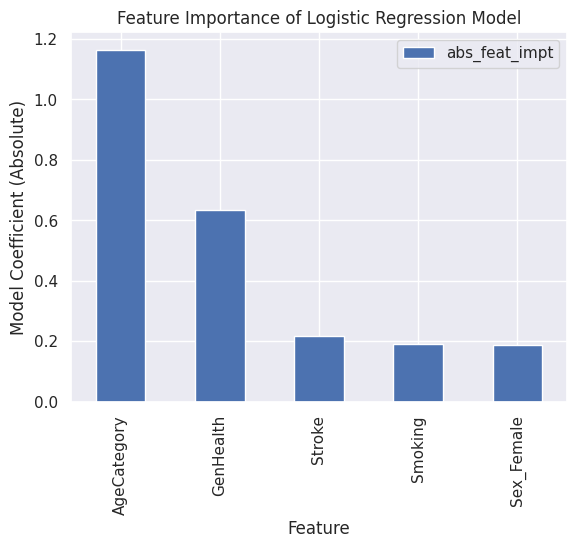

In [ ]:
df_lgr_feature_importance = pd.DataFrame(lgr_randomized_search.best_estimator_.coef_, columns=encoded_df_heart.columns[1:]).T
df_lgr_feature_importance.columns=['feat_impt']
df_lgr_feature_importance['abs_feat_impt'] = np.abs(df_lgr_feature_importance['feat_impt'])
df_lgr_feature_importance.sort_values(by='abs_feat_impt', ascending=False)[['abs_feat_impt']].head(5).plot(kind='bar')

plt.title('Feature Importance of Logistic Regression Model')
plt.xlabel('Feature')
plt.ylabel('Model Coefficient (Absolute)')

## 5.2 Random Forest
- Random Forest takes advantage of ensembling, and can provide good interpretability

### 5.2.1 Baseline Model

In [ ]:
rf_baseline = RandomForestClassifier(random_state = random_state)
rf_baseline.fit(X_train_scaled_oversampled, y_train_oversampled)

RandomForestClassifier(random_state=42)

In [ ]:
# Baseline model train set score
y_train_pred = rf_baseline.predict(X_train_scaled_oversampled)
print(f"Train Set Score: {f1_score(y_train_oversampled, y_train_pred)}")

# Baseline model test set score
y_pred = rf_baseline.predict(X_test_scaled)
print(f"Test Set Score: {f1_score(y_test, y_pred)}")

Train Set Score: 0.9981449661905129
Test Set Score: 0.26365038560411314


### 5.2.2 Hyperparameter Tuning

**Hyperparameters to consider:**
- The baseline model is overfitted
 (f1_score: train set - 0.998, test set - 0.263 )
- To avoid overfitting, we can tune 5 hyperparameters: max_depth, n_estimators, max_features, max_leaf_nodes and class_weight


**Note:**
- We also perform 5-fold stratified cross validation, which helps to evaluate the performance of the model on "unseen" data and hence reduce the chance of overfitting eventually on the test set
- Also, we chose to utilize RandomizedSearch as the hyperparameter tuning strategy due to the better trade off between efficiency (i.e. time) and results (compared to GridSearch)

In [ ]:
## To further refine hyperparameter tuning - @Ko

# # Specify which hyperparameters to tune and their respective ranges
params = {
    'n_estimators': [100, 120, 150, 180, 210],
    'max_depth': [3, 5, 10, 20, 30, None],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [3,6,9, None],
    'class_weight': ['balanced', 'balanced_subsample', None],
}

# ## Can consider randomizedsearchcv:
rf_randomized_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=random_state),
    params,
    n_iter=6, # ideally run n_iter=10, reduced due to long runtime for project submission purposes
    scoring='f1',
    cv = 3,  # ideally run cv=5, reduced due to long runtime for project submission purposes
    verbose=4,
    n_jobs = -1)

# # Fit the model to do the hyperparameter tuning
rf_randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [3, 5, 10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [3, 6, 9, None],
                                        'n_estimators': [100, 120, 150, 180,
                                                         210]},
                   scoring='f1', verbose=4)

In [ ]:
print(f"Best hyperparamters: {rf_randomized_search.best_params_}")
print(f"Best F1-score: {rf_randomized_search.best_score_}")

Best hyperparamters: {'n_estimators': 100, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 5, 'class_weight': None}
Best F1-score: 0.08667009296240709


### 5.2.3 Evaluate on test set (Default Threshold=0.5)
- We first evaluate our model on the test set, using a default (0.5)
- We see that the Test F1-Score stands at 0

In [ ]:
y_pred = rf_randomized_search.predict(X_test_scaled)
print(f"Random Forest Test F1-Score (default threshold): {f1_score(y_test, y_pred)}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Random Forest Test F1-Score (default threshold): 0.0


### 5.2.4 Threshold Tuning
- Through threshold tuning, we see that the best F1-Score (0.32) can be achieved at threshold=0.059

In [ ]:
best_rf_threshold, best_rf_score = get_optimal_threshold(rf_randomized_search, X_test_scaled, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Best Threshold: 0.059000000000000004, Best F1-Score: 0.3161612471075387


### 5.2.5 Final evaluation on test set using optimized threshold

In [ ]:
# Compute final model test score
y_pred_rf = (rf_randomized_search.predict_proba(X_test_scaled)[:, 1] >= best_rf_threshold).astype('int')
rf_f1score = f1_score(y_test, y_pred_rf)
print(f"Random Forest F1-Score: {rf_f1score}")

# Generate confusion matrix
print("\nRandom Forest Confusion Matrix")
rf_confusion = confusion_matrix(y_test, y_pred_rf)
print(rf_confusion)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Random Forest F1-Score: 0.3161612471075387

Random Forest Confusion Matrix
[[50133  8234]
 [ 2996  2596]]


### 5.2.6 Feature Importance
- Now, we look at the coefficients of the Random Forest model and observe which were the most important features
- By plotting the feature importances of the model, we can see that the Top 2 contributing features were AgeCategory and GenHealth
- This is aligned with our EDA - where we see a correlation between these 2 variables and our labels

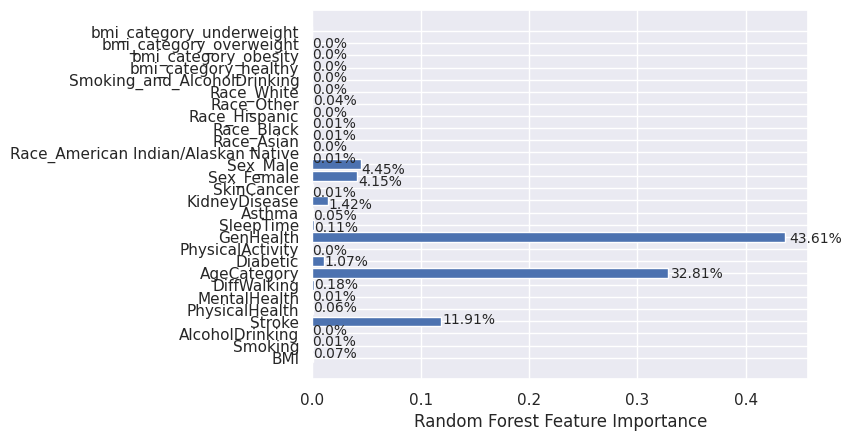

In [ ]:
fig, ax = plt.subplots()
plt.barh(features.columns, rf_randomized_search.best_estimator_.feature_importances_)
plt.xlabel("Random Forest Feature Importance")
for i, v in enumerate(rf_randomized_search.best_estimator_.feature_importances_):
  ax.text(v*1.01, i*0.95, str(round(v*100,2))+'%', fontdict=dict(fontsize=10))

## 5.3 XGBoost

- In addition, we also consider an algorithm not taught in class - XGBoost, which is one of the better performing non-Deep Learning ML algorithm

### 5.3.1 Baseline Model

In [ ]:
# Initiate baseline model and train
xgb = XGBClassifier(random_state=random_state)
xgb.fit(X_train_scaled_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

- We see that there are signs of overfitting as the Train Set Score (0.93) is significantly higher than the Test Set Score (0.24)

In [ ]:
# Baseline model train set score
y_train_pred_prob = xgb.predict(X_train_scaled_oversampled)
y_train_pred = [round(x) for x in y_train_pred_prob] #Prob=0.5 as cutoff
print(f"Train Set Score F1-score: {f1_score(y_train_oversampled, y_train_pred)}")

# Baseline model test set score
y_pred_prob = xgb.predict(X_test_scaled)
y_pred = [round(x) for x in y_pred_prob] #Prob=0.5 as cutoff
print(f"Test Set F1-score: {f1_score(y_test, y_pred)}")

Train Set Score F1-score: 0.9328123751963577
Test Set F1-score: 0.2415562716314596


### 5.3.2 Hyperparameter Tuning

**Hyperparameters to consider:**
- max_depth: Maximum depth of a tree, increasing will make model more complex (and might overfit)
- learning_rate: Step size shrinkage used in update to prevent overfiting - the higher LR the higher chance for overfitting
- n_estimators: Number of trees -the more trees the lower chance for overfitting

**Note:**
- We also perform 5-fold stratified cross validation, which helps to evaluate the performance of the model on "unseen" data and hence reduce the chance of overfitting eventually on the test set
- Also, we chose to utilize RandomizedSearch as the hyperparameter tuning strategy due to the better trade off between efficiency (i.e. time) and results (compared to GridSearch)

In [ ]:
## Planned to perform hyperparameter tuning - but training time took too long, to use default fixed hyperparameters instead

# # Set up params for XGBoost
# xgb_params = {
#  'max_depth': range(0, 51),
#  'learning_rate': [0.0001, 0.001, 0.1, 0.2, 0.5, 0.7],
#  'n_estimators': range(100, 1001)
# }

# xgb_randomized_search = RandomizedSearchCV(
#     estimator=XGBClassifier(random_state=random_state),
#     param_distributions=xgb_params,
#     cv=2,  # ideally run cv=5, reduced due to long runtime for project submission purposes
#     n_iter=1,  #  n_iter=1 theoratically does not make sense here as it only tries for one hyperparatmer combination. Ideally run n_iter=10, reduced due to long runtime for project submission purposes.
#     scoring='f1',
#     refit=True,
#     verbose=4
# )

# # Fit data
# xgb_randomized_search.fit(X_train_scaled_oversampled, y_train_oversampled)

# Using default hyperparameters
xgb_randomized_search = XGBClassifier(random_state=random_state)
xgb_randomized_search.fit(X_train_scaled_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
# print(f"Best hyperparamters: {xgb_randomized_search.best_params_}")
# print(f"Best F1-score: {xgb_randomized_search.best_score_}")

### 5.3.3 Evaluate on test set (Default Threshold=0.5)
- We first evaluate our model on the test set, using a default (0.5)
- We see that the Test F1-Score stands at 0.24

In [ ]:
y_pred_proba = xgb_randomized_search.predict_proba(X_test_scaled)
y_pred = (y_pred_proba[:, 1] >= 0.5).astype('int')
print(f"XGBoost Test F1-Score (default threshold): {f1_score(y_test, y_pred)}")

XGBoost Test F1-Score (default threshold): 0.2415562716314596


### 5.3.4 Threshold Tuning
- Through threshold tuning, we see that the best F1-Score (0.36) can be achieved at threshold=0.223

In [ ]:
def get_optimal_threshold(classifier, X_test, y_test):
  thresholds = np.arange(0, 1, 0.001)
  y_pred_proba = classifier.predict_proba(X_test)
  probabilities = y_pred_proba[:, 1]
  scores_list = [f1_score(y_test, (probabilities >= threshold).astype('int')) for threshold in thresholds]
  ind = np.argmax(scores_list)
  best_threshold = thresholds[ind]
  best_score = scores_list[ind]
  print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_score}")
  return (best_threshold, best_score)

In [ ]:
best_xgb_threshold, best_xgb_score = get_optimal_threshold(xgb_randomized_search, X_test_scaled, y_test)

Best Threshold: 0.223, Best F1-Score: 0.3622874472002599


### 5.3.5 Final evaluation on test set using optimized threshold

In [ ]:
# Compute final model test score
y_pred_xgb = (xgb_randomized_search.predict_proba(X_test_scaled)[:, 1] >= best_xgb_threshold).astype('int')
xgb_f1score = f1_score(y_test, y_pred_xgb)
print(f"XGBoost F1-Score: {xgb_f1score}")

# Generate confusion matrix
print("\nXGBoost Confusion Matrix")
xgb_confusion = confusion_matrix(y_test, y_pred_xgb)
print(xgb_confusion)

XGBoost F1-Score: 0.3622874472002599

XGBoost Confusion Matrix
[[48838  9529]
 [ 2247  3345]]


### 5.3.6 Feature Importance
- Similarly, we can see that AgeCategory and GenHealth are the 2 most importance features - aligning with our correlation study

Text(0.5, 0, 'Feature Importance')

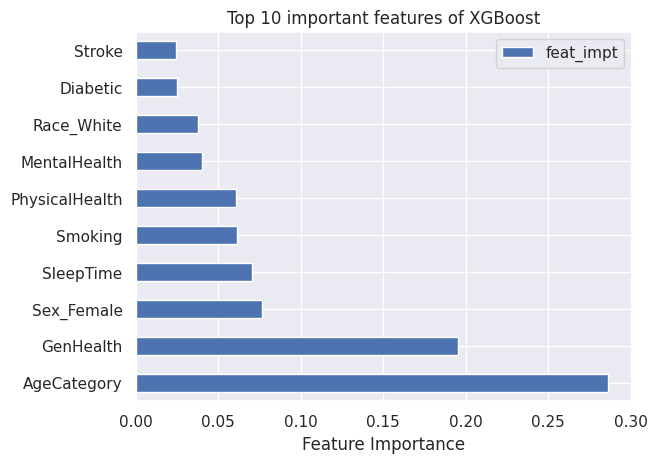

In [ ]:
df_xgb_feat_importance = pd.DataFrame(xgb_randomized_search.feature_importances_, index=encoded_df_heart.columns[1:])
df_xgb_feat_importance.columns = ['feat_impt']
df_xgb_feat_importance.sort_values(by='feat_impt', ascending=False).head(10).plot(kind='barh')

plt.title('Top 10 important features of XGBoost')
plt.xlabel('Feature Importance')

#6. Comparing Models and Final Selection

- **Criteria 1: Model Performance**
  - LogisticRegression model (at 0.39 F1-Score) had the highest performance and is prioritized when utilizing this criteria
  - That said, the model performance is not ideal and can be further improved (see section: Reflection and Areas for Improvement)
- **Criteria 2: Model Explainability and Ease of Explaination**
  - In a health care case study, explainability of model is of utmost importance due to the need for intepretation of our predictions and reasons for it (i.e feature)
  - **Hence, we will be choosing LogisticRegression as as our final model due to its ease of intepretation**


**Possible Reasons for LogisticRegression model's better performance:**
1. Features are 'simple' and logistic regression was sufficient to capture the relationship
2. Due to computing resources, hyper parameter tuning weren't performed with enough iterations for other algorithms - whereas LogisticRegression had adequete iterations. Hence, LogisticRegression turned out to be performing (marginally) better.

6.1 Test F1-Score

In [ ]:
# print('Test Accuracy for Logistic Regression: ', log_acc)
# print('Test Accuracy for Random Forest: ' + rf_acc)
# print('Test Accuracy for XGBoost: ' + xg_acc)

print(f"Test F1-Score for Logistic Regression: {best_lgr_score}")
print(f"Test F1-Score for Random Forest: {rf_f1score}")
print(f"Test F1-Score for XGBoost: {best_xgb_score}")

Test F1-Score for Logistic Regression: 0.3915322306173848
Test F1-Score for Random Forest: 0.3161612471075387
Test F1-Score for XGBoost: 0.3622874472002599


6.2 Confusion Matrix

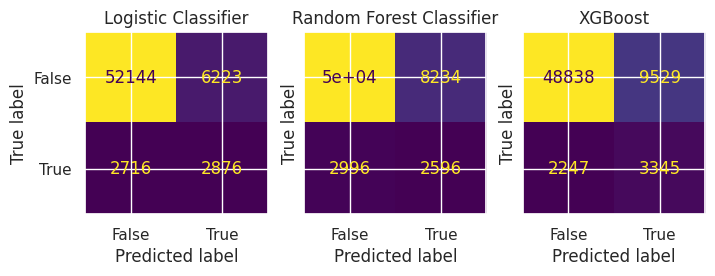

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 6), sharey='row')

cm_dict = {'Logistic Classifier' : lgr_confusion,
           'Random Forest Classifier' : rf_confusion,
           'XGBoost' : xgb_confusion}

for i, (key, model) in enumerate(cm_dict.items()):
    cm = ConfusionMatrixDisplay(
        confusion_matrix=model,
        display_labels=[False, True]).plot(ax=ax[i])
    cm.ax_.set_title(key)
    cm.im_.colorbar.remove()

# 7. Reflection and Areas for Improvament

1. **Source for more data points** - we could potentially expand our data points/row through looking through more editions of similar surveys, this case we would have a richer pool of data that could potentially improve our model

2. **More feature engineering** - although features like Age and General Health were our most important features, they still do not necessarily have the highest correlation with our features. Hence, if we performed more feature engineering, we might have discovered better features

3. **Further tuning and model adjustment to address overfitting** - despite performing hyperparameter tuning, we still see signs of overfitting through a lower test score vs. higher train score scenarios. We could potentially futher perform feature selection or further hyper parameter tuning that could address overfitting. Also, due to resources limitations, we couldn't perform hyperparameter tuning/with enough n_iters - hence limiting the params we tested